In [1]:
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
spark = SparkSession \
    .builder.master('local') \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://mongo:27017/test.coll") \
    .config("spark.mongodb.output.uri", "mongodb://mongo:27017/test.coll") \
    .config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")\
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-edda7b98-c8fd-4326-9e95-34b3f57b49fc;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 325ms :: artifacts dl 13ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts

# DATA PROCESSING

In [3]:
filepath = "/home/jovyan/data"
filename = "OnlineRetail.xlsx"

In [4]:
def ConnectToMongoDB (dbname,collectname):
    # db : name of Mongo database (str)
    # collection: name of collection (str)
    try:
        conn = MongoClient("mongodb://mongo:27017") # add your MDB adress
        dblist = conn.list_database_names()
        if (dbname in dblist) and(collectname in conn[dbname].list_collection_names()):
            print("The database and the collection exist")
        elif (dbname in dblist) and (collectname not in conn[dbname].list_collection_names()):
            newcollection = conn[dbname][collectname]
            print("Created a new collection called %s" %collectname)
        else:
            newdb = conn[dbname]# The new database isn't created until we do your first insert
            print("Created a new database called %s" %dbname)
            newcollection = conn[dbname][collectname]
            print("Create a new collection called %s" %collectname)
           
        return conn[dbname],conn[dbname][collectname]
    except:
        print("Could not connect to MongoDB") 
        

In [5]:
# Read and convert dataset to pandas dataframe and Spark Datframe
def ReadConvertFile(filepath,filename ):
    # read the Excel file as a DataFrame\n",
    df = pd.read_excel(filepath+ '/' + filename)
    # make apropriate column types
    for numcol in ['Quantity']:
        df[numcol] = pd.to_numeric(df[numcol], errors = 'coerce').astype(int)
    for strcol in ['InvoiceNo','StockCode','Description','Country']:
        df[strcol] = df[strcol].astype(str)
    df['UnitPrice'] = df['UnitPrice'].astype(float)
    df['CustomerID'] = str(df['CustomerID']).split('.')[0].split()[1]# remove decimals and blank spaces
    df = df[~df['Description'].str.startswith('?')].copy()# remove rows where Description starts with ?
    sparkdf = spark.createDataFrame(df)
    return df,sparkdf

In [6]:
# Write and load the spark DF to MongoDB
def WriteReadMongoDb (dbname,collectname):
    '''
    dbname : name of Mongo database (str)
    collection: name of collection (str)
    '''
    sparkdf = ReadConvertFile(filepath,filename)[1]
    
    # write data to MongoDB
    sparkdf.write.format("com.mongodb.spark.sql.DefaultSource")\
       .mode("overwrite")\
       .option("database",dbname)\
       .option("collection",collectname)\
       .save()\
    
    # load data from MongoDB
    mongoDF = spark.read\
      .format("com.mongodb.spark.sql.DefaultSource")\
      .option("database",dbname)\
      .option("collection",collectname)\
      .load()
    
    return mongoDF

In [7]:
mongoDF = WriteReadMongoDb('TestForKCL','OnlineRetail')

21/07/27 06:40:22 WARN TaskSetManager: Stage 0 contains a task of very large size (34669 KiB). The maximum recommended task size is 1000 KiB.


In [8]:
# check if data has been fully loaded to MongoDB 
print(ReadConvertFile(filepath,filename)[0].shape)
print((mongoDF.count(), len(mongoDF.columns)))

(541842, 8)


(541842, 9)


In [9]:
# Creat a temporary table for the dataframe to do analysis
mongoDF.createOrReplaceTempView("temp")

# DATA ANALYSIS

## Group all transactions by invoice

In [10]:
def groupTransbyInvoice (mongoDF):
    
    mongoDF.createOrReplaceTempView("temp")
    groupbyInvoice = spark.sql("SELECT InvoiceNo, Count (*) FROM temp Group By InvoiceNo")
    groupbyInvoiceRDD = groupbyInvoice.rdd
    result = groupbyInvoiceRDD.map(tuple)
    result = result.collect()
    return result    

In [11]:
groupTransbyInvoiceOut = groupTransbyInvoice(mongoDF)

# Which product sold the most?

In [12]:
def mostsoldproduct(mongoDF):
    mongoDF.createOrReplaceTempView("temp")
    mostsoldproduct = spark.sql("SELECT Description, Sum (Quantity) as TotalQuantity \
                            FROM temp \
                          Group By Description \
                              Order by TotalQuantity Desc Limit 1")
    prod = mostsoldproduct.collect()[0][0]
    mostsoldproduct.show()
    return prod

In [13]:
 mostsoldproduct(mongoDF)

+--------------------+-------------+
|         Description|TotalQuantity|
+--------------------+-------------+
|WORLD WAR 2 GLIDE...|        53847|
+--------------------+-------------+



'WORLD WAR 2 GLIDERS ASSTD DESIGNS'

## Which customer spent the most money?

In [14]:
def mostspendclient(mongoDF):
    mongoDF.createOrReplaceTempView("temp")
    mostspendclient =spark.sql("SELECT CustomerID, Sum(T.Spend) as TotalSpend FROM\
                             (SELECT CustomerID, Quantity*UnitPrice as Spend \
                                FROM temp) as T \
                               Group By CustomerID \
                              Order by TotalSpend Desc Limit 1")
    clientID = mostspendclient.collect()[0][0]
    mostspendclient.show()
    return clientID

In [15]:
mostspendclient(mongoDF)

+----------+-----------------+
|CustomerID|       TotalSpend|
+----------+-----------------+
|     17850|9747747.933998458|
+----------+-----------------+



'17850'

## Provide a chart showing the distribution of each product for each of the available countries

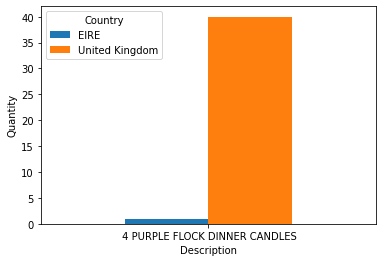

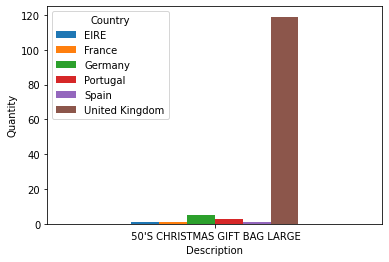

In [16]:
# convert the spark dataframe to pandas dataframe
pdDF = mongoDF.toPandas()

# group by Product,Country and count the number of each product bought by each country
prodbycountry = pdDF.groupby(['Description', 'Country']).size().reset_index(name='count')

# use a pivot table to display countries in columns and volumes in rows
prodbycountrypiv = prodbycountry.pivot(index ='Description', columns='Country', values='count')

# Plot charts to show the distribution of some of products for each countries available ( drop al Nan)
n = 2 # put the number of products to show
for i in range(n):
    df_sample = prodbycountrypiv[i:i+1]
    df_sample1 = df_sample.dropna(axis=1, how='all') # drop all columns containing Nan
    chart = df_sample1.plot(kind='bar',figsize=(6,4));
    chart.set_ylabel("Quantity");
    plt.xticks(rotation=0, horizontalalignment="center")

## Create a new collection on Mongo DB to store the distribution of each product for each of the available countries¶

In [17]:
# replace Nan by 0 to insert data to a new MongoDb collection
prodbycountrypiv = prodbycountrypiv.fillna(0)

print("Total number of products: {}\nTotal number of countries: {}".\
      format(prodbycountrypiv.shape[0], prodbycountrypiv.shape[1]))  

Total number of products: 4211
Total number of countries: 38


In [18]:
# prepare data to insert to the new collection on MongoDb
prodbycountryToMongo = []
for i in range(len(prodbycountrypiv)):
    Prod = {"ProdName": prodbycountrypiv.iloc[[i]].index[0]}
    VolbyCountry = []
    Prod["Countries"]= VolbyCountry
    prodbycountryToMongo.append(Prod)
    for j in range(len(prodbycountrypiv.iloc[[i]].columns)):
        d = {}
        colname= str(prodbycountrypiv.iloc[[i]].columns[j])
        d['country'] = prodbycountrypiv.iloc[[i]].columns[j]
        d['vol'] = int(prodbycountrypiv.iloc[i][colname])
        VolbyCountry.append(d)
        
# Use the function ConnectToMongoDB to connnect to MongoDB and create a new collection called ProdCountry
newcollection = ConnectToMongoDB ('TestForKCL','ProdCountry')[1]

# insert the data to the new collection
newcollection.insert_many(prodbycountryToMongo)

# check data om the new collection
print((newcollection.count(), newcollection.columns))

The database and the collection exist
(12633, Collection(Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True), 'TestForKCL'), 'ProdCountry.columns'))


# What is the average unit price?

In [19]:
def avgprice (mongoDF):
    mongoDF.createOrReplaceTempView("temp")
    avgprice =spark.sql("SELECT Description, Avg(UnitPrice) as AvgUnitPrice \
                    FROM temp\
                       Group By Description \
                        order by  AvgUnitPrice desc ")
    avgpriceRDD = avgprice.rdd
    result = avgpriceRDD.map(tuple)
    result = result.collect()
    return result

In [20]:
avgpriceOut = avgprice(mongoDF)

## Give a chart showing the distribution of prices

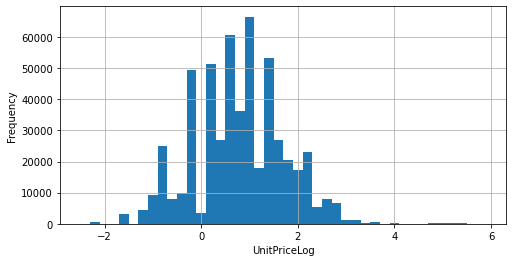

In [21]:
# Convert the UnitPrice to Log to avoid a very large of data dispersion 
UnitPriceLog= np.log(pdDF['UnitPrice'])
bin_values = np.arange(start=-2.5, stop=6, step=0.2)
UnitPriceLog.hist(bins=bin_values, figsize=[8,4]);
plt.xlabel('UnitPriceLog');
plt.ylabel('Frequency');

## Ratio between price and quantity for each invoice

In [22]:
def ratioPriceQuant(mongoDF):
    mongoDF.createOrReplaceTempView("temp")
    ratio = spark.sql("SELECT InvoiceNo, SUM(UnitPrice)/SUM(Quantity) as Ratio \
                            FROM temp Group By InvoiceNo")
    ratioRDD = ratio.rdd
    result = ratioRDD.map(tuple)
    result = result.collect()
    return result

In [23]:
ratioPriceQuantOut = ratioPriceQuant(mongoDF)

## UNIT TESTS

In [24]:
import unittest

class TestNotebook(unittest.TestCase):
    
    filepath = "/home/jovyan/data"
    filename = "OnlineRetail.xlsx"
    dbname = 'TestForKCL'
    collectname = 'OnlineRetail'
    sparkdf = ReadConvertFile(filepath,filename)[1]
    mongoDF = WriteReadMongoDb(dbname,collectname)
    
    def test_mostsoldproduct(self):
        actual =  mostsoldproduct(mongoDF)
        expected = 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'
        self.assertEqual(actual, expected)
    
    def test_mostspendclient(self):
        actual = mostspendclient(mongoDF)
        expected = '17850'
        self.assertEqual(actual, expected)
        
    def test_groupTransbyInvoice(self):
        actual = groupTransbyInvoice(mongoDF)
        expected = groupTransbyInvoiceOut
        self.assertListEqual(actual, expected)  
        
    def test_avgprice(self):
        actual = avgprice(mongoDF)
        expected = avgpriceOut
        self.assertListEqual(actual, expected)
        
    def test_ratioPriceQuant(self):
        actual = ratioPriceQuant(mongoDF)
        expected = ratioPriceQuantOut
        self.assertListEqual(actual, expected)
        


unittest.main(argv=[''], verbosity=2, exit=False)

21/07/27 06:51:36 WARN TaskSetManager: Stage 24 contains a task of very large size (34669 KiB). The maximum recommended task size is 1000 KiB.
/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58986), raddr=('127.0.0.1', 36751)>
  self._sock = None
FAIL
/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60530), raddr=('127.0.0.1', 39983)>
  self._sock = None
FAIL
/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51108), raddr=('127.0.0.1', 35081)>
  self._sock = None
ok                                                                              
test_mostspendclient (__main__.TestNotebook) ... 

+--------------------+-------------+
|         Description|TotalQuantity|
+--------------------+-------------+
|WORLD WAR 2 GLIDE...|        53847|
+--------------------+-------------+



/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 51142), raddr=('127.0.0.1', 40271)>
  self._sock = None
ok                                                                              
test_ratioPriceQuant (__main__.TestNotebook) ... 

+----------+-----------------+
|CustomerID|       TotalSpend|
+----------+-----------------+
|     17850|9747747.933999557|
+----------+-----------------+



/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52740), raddr=('127.0.0.1', 43189)>
  self._sock = None
FAIL

FAIL: test_avgprice (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2947/855353000.py", line 30, in test_avgprice
    self.assertListEqual(actual, expected)
AssertionError: Lists differ: [('AM[22 chars]882352), ('PICNIC BASKET WICKER 60 PIECES', 64[207352 chars]333)] != [('AM[22 chars]882353), ('PICNIC BASKET WICKER 60 PIECES', 64[207614 chars]333)]

First differing element 0:
('AMAZON FEE', 7324.784705882352)
('AMAZON FEE', 7324.784705882353)

Diff is 568051 characters long. Set self.maxDiff to None to see it.

FAIL: test_groupTransbyInvoice (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (mo